In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def pred_bin_out(row, nBins, binTimeRes):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    return row

In [3]:
colNames = ["date"]
nBins = 1
binRes = 90
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
colNames += ["label", "del_minutes","pred_label"]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
predDF = pandas.read_csv("../data/resnet_test_data_pred.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF = predDF.apply( pred_bin_out, args=(nBins,binRes,),\
                      axis=1 )
predDF.head()

,date,bin_0,label,del_minutes,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type
0,2015-01-27 22:50:00,1,1,29.0,1,0.316822,0.683178,1,TP
1,2015-01-27 22:55:00,1,1,24.0,1,0.323714,0.676286,1,TP
2,2015-01-27 23:00:00,1,1,19.0,1,0.348204,0.651796,1,TP
3,2015-01-27 23:05:00,1,1,14.0,1,0.350489,0.649511,1,TP
4,2015-01-27 23:10:00,1,1,9.0,1,0.329317,0.670683,1,TP


In [4]:
start_date = predDF["date"].min() - datetime.timedelta(hours=2)
end_date = predDF["date"].max()
print start_date, end_date

2015-01-27 20:50:00 2017-12-31 23:55:00


In [5]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "omni_sw_imf.sqlite"
omn_table_name = "imf_sw"
timeDelHours = 0.5

In [6]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, Bz, Vx, By FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
omnDF = pandas.read_sql(command, conn)
# drop nan's
omnDF.dropna(inplace=True)
# Change the index to datetime
omnDF.set_index(omnDF["datetime"], inplace=True)
omnDF.head()

,datetime,Bz,Vx,By
datetime,,,,
2015-01-27 21:02:00,2015-01-27 21:02:00,-4.18,-471.6,-0.10
2015-01-27 21:03:00,2015-01-27 21:03:00,-4.00,-471.6,-1.09
2015-01-27 21:04:00,2015-01-27 21:04:00,-3.67,-472.8,-2.03
2015-01-27 21:05:00,2015-01-27 21:05:00,-4.78,-478.8,-1.25
2015-01-27 21:06:00,2015-01-27 21:06:00,-4.64,-478.8,-1.19


In [7]:
# get the dates from the sel type
# and store the results in a dict!
delTimeList = [ 2 ]
predOmnPrfDFList = []
for _pt in predDF["pred_type"].unique():
    selDFDates = predDF[ predDF["pred_type"] == _pt ]["date"].tolist()
    # Now we need the time history at each of these dates
    for _dtl in delTimeList:
        for _cd in selDFDates:
            _ed =_cd - datetime.timedelta(minutes=int(_dtl*60))
            _resOmnDF = omnDF[ _ed : _cd ]
            _resOmnDF["delTimeOnset"] = (_resOmnDF["datetime"]\
                                         - _cd).astype('timedelta64[m]')
            _resOmnDF["pred_type"] = _pt
            _resOmnDF["pred_date"] = _cd
            _resOmnDF = _resOmnDF[["Bz", "Vx", "By",\
                            "delTimeOnset", "pred_date", "pred_type"]]
            _resOmnDF.reset_index(inplace=True, drop=True)
            predOmnPrfDFList.append( _resOmnDF )
            
predOmnPrflDF = pandas.concat(predOmnPrfDFList)
predOmnPrflDF.head()

,Bz,Vx,By,delTimeOnset,pred_date,pred_type
0,-4.18,-471.6,-0.10,-108.0,2015-01-27 22:50:00,TP
1,-4.00,-471.6,-1.09,-107.0,2015-01-27 22:50:00,TP
2,-3.67,-472.8,-2.03,-106.0,2015-01-27 22:50:00,TP
3,-4.78,-478.8,-1.25,-105.0,2015-01-27 22:50:00,TP
4,-4.64,-478.8,-1.19,-104.0,2015-01-27 22:50:00,TP


In [8]:
predOmnPrflDF.to_csv("../data/omn_profile_cat.csv")

In [112]:
meanParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).mean().reset_index()
meanParamDF.columns = ["delTimeOnset", "pred_type", "mean_Bz", "mean_Vx", "mean_By"]
stdParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).std().reset_index()
stdParamDF.columns = ["delTimeOnset", "pred_type", "std_Bz", "std_Vx", "std_By"]
meanParamDF = pandas.merge( meanParamDF, stdParamDF, on=["delTimeOnset", "pred_type"] )
meanParamDF.head()

,delTimeOnset,pred_type,mean_Bz,mean_Vx,mean_By,std_Bz,std_Vx,std_By
0,-120.0,FN,-0.094075,-425.697583,0.097218,2.737739,81.498419,3.797702
1,-120.0,FP,-0.936080,-495.462302,0.699968,3.616415,101.988021,4.444634
2,-120.0,TN,0.576982,-394.401163,0.023524,2.947879,71.415640,3.697742
3,-120.0,TP,-0.897667,-524.128803,0.974046,4.215549,105.177770,4.585725
4,-119.0,FN,-0.128501,-425.998936,0.037751,2.744274,81.425284,3.877248


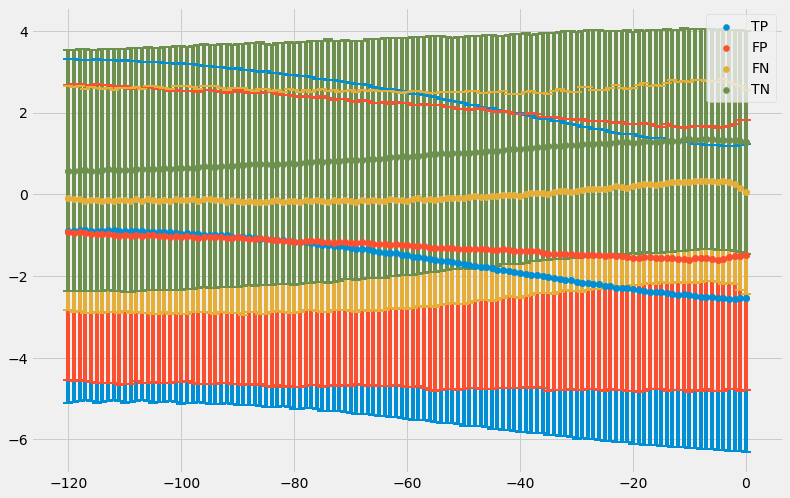

In [132]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

for _pd in predTypeList:
    selDF = meanParamDF[ meanParamDF["pred_type"] == _pd ]
    ax.scatter( selDF["delTimeOnset"].values, selDF["mean_Bz"].values, label=_pd )
    ax.errorbar( selDF["delTimeOnset"].values, selDF["mean_Bz"].values,\
               yerr=selDF["std_Bz"].values, label='', capthick=2., capsize=5., fmt='o')
plt.legend()
f.savefig("../plots/epoch_pred_types_Bz_median.pdf")
f.savefig("../plots/epoch_pred_types_Bz_median.eps")

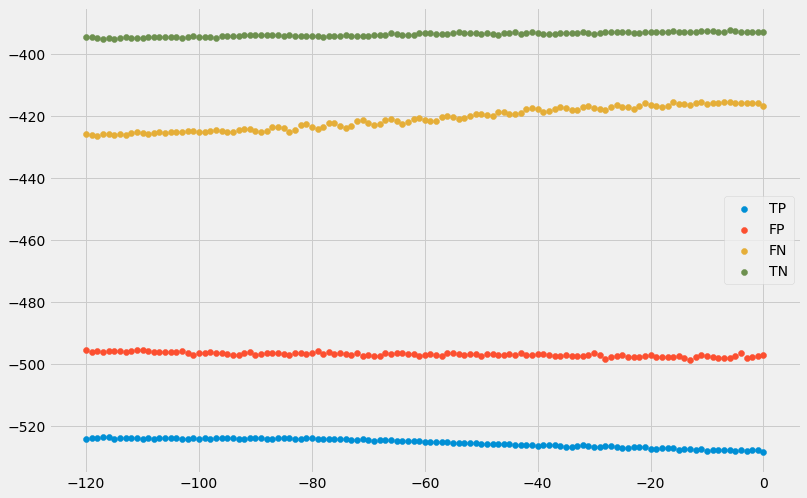

In [114]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

for _pd in predTypeList:
    selDF = meanParamDF[ meanParamDF["pred_type"] == _pd ]
    ax.scatter( selDF["delTimeOnset"].values, selDF["mean_Vx"].values, label=_pd )
#     ax.errorbar( selDF["delTimeOnset"].values, selDF["mean_Vx"].values,\
#                yerr=selDF["std_Vx"].values, label='', capthick=2., capsize=5., fmt='o')
plt.legend()
f.savefig("../plots/epoch_pred_types_Vx_median.pdf")
f.savefig("../plots/epoch_pred_types_Vx_median.eps")

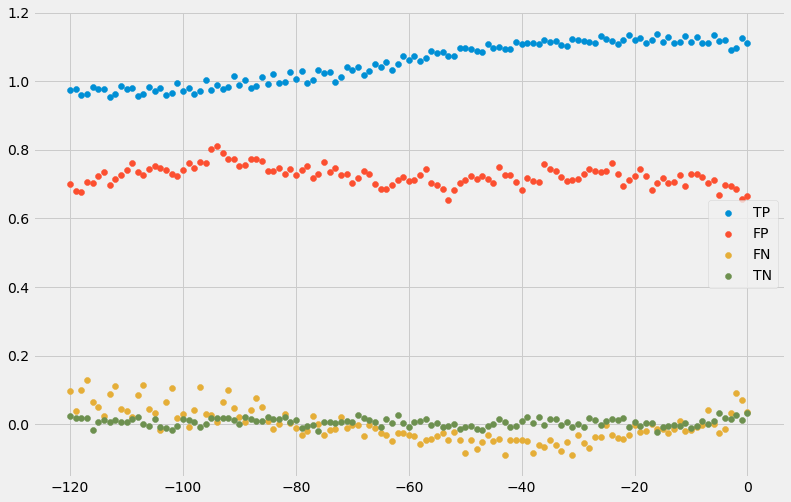

In [115]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

for _pd in predTypeList:
    selDF = meanParamDF[ meanParamDF["pred_type"] == _pd ]
    ax.scatter( selDF["delTimeOnset"].values, selDF["mean_By"].values, label=_pd )
#     ax.errorbar( selDF["delTimeOnset"].values, selDF["mean_By"].values,\
#                yerr=selDF["std_By"].values, label='', capthick=2., capsize=5., fmt='o')
plt.legend()
f.savefig("../plots/epoch_pred_types_By_median.pdf")
f.savefig("../plots/epoch_pred_types_By_median.eps")

In [158]:
# Bin by delTBins
delTBins = range(-120,10,5)
# get the min al in the next 30 min
oldColNames = predOmnPrflDF.columns.tolist()
predDF2 = pandas.concat( [ predOmnPrflDF, \
                    pandas.cut( predOmnPrflDF["delTimeOnset"], \
                               bins=delTBins ) ], axis=1 )
predDF2.columns = oldColNames + ["delT_bin"]
predDF2 = predDF2[ predDF2["pred_type"].isin([ "TP", "FP", "FN", "TN"]) ]

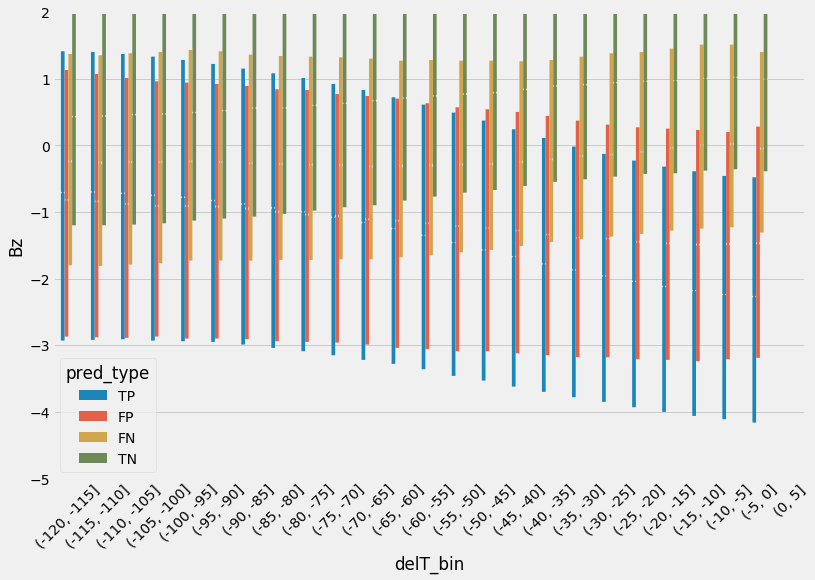

In [159]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.boxplot(x="delT_bin", y="Bz", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, showfliers=False,ax=ax, linewidth=0.,\
            notch=True, width=0.5)

ax.set_ylim([-5,2])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps")

In [157]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "smu_sml_sme.sqlite"
omn_table_name = "smusmlsme"
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.set_index(smlDF["datetime"], inplace=True)
smlDF.head()

,datetime,al,ae,au
datetime,,,,
2015-01-27 20:50:00,2015-01-27 20:50:00,-250,433,183
2015-01-27 20:51:00,2015-01-27 20:51:00,-248,430,182
2015-01-27 20:52:00,2015-01-27 20:52:00,-253,439,186
2015-01-27 20:53:00,2015-01-27 20:53:00,-258,443,185
2015-01-27 20:54:00,2015-01-27 20:54:00,-262,452,190


In [ ]:
def get_sml_vars(row):
    """
    Get mean, median, std, min and max of sml 
    during various substorms over the next interval range.
    """
    delTimeList = [30, 60]#[ 15, 30, 60, 120 ]
    for _dtl in delTimeList:
        _pd = row["pred_date"] - datetime.timedelta(minutes=10)
        _cd = row["pred_date"] + datetime.timedelta(minutes=1)
        _ed = row["pred_date"] + datetime.timedelta(minutes=_dtl)
        _resDF = smlDF[ _cd : _ed ]
        _baselineAl = smlDF[ _pd : _cd ]["al"].median()
        _baselineAe = smlDF[ _pd : _cd ]["ae"].median()
        row["mean_al_" + str(_dtl)] = _resDF["al"].mean()
        row["median_al_" + str(_dtl)] = _resDF["al"].median()
        row["min_al_" + str(_dtl)] = _resDF["al"].min()
        row["max_al_" + str(_dtl)] = _resDF["al"].max()
        # difference between current AL and minimum in the next bin
        # note this is defined to be negative, for easy binning etc
        row["al_dip" + str(_dtl)] = _resDF["al"].min() - _baselineAl
        row["ae_dip" + str(_dtl)] = _resDF["ae"].max() - _baselineAe
    return row

predDF2 = predDF2.apply( get_sml_vars, axis=1 )
predDF2.head()